In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay

from mpitree.tree import DecisionTreeClassifier

- @tree.cyclic
- DecisionTreeClassifier(...,n_jobs=5)

In [2]:
!mpirun -n 4 python3 -c "exec('from mpitree.tree import ParallelDecisionTreeClassifier\nfrom sklearn.datasets import load_iris\niris = load_iris()\nclf = ParallelDecisionTreeClassifier(max_depth=3).fit(iris.data[:, :2], iris.target)\nif not clf.WORLD_RANK:print(clf.export_text(feature_names=iris.feature_names, class_names=iris.target_names))')"

┌── sepal length (cm)
│  ├── sepal width (cm) [> 5.50]
│  │  ├── sepal length (cm) [> 3.60]
│  │  │  ├── setosa [<= 5.80]
│  │  │  └── virginica [> 5.80]
│  │  └── sepal length (cm) [<= 3.60]
│  │     ├── versicolor [<= 6.20]
│  │     └── virginica [> 6.20]
│  └── sepal width (cm) [<= 5.50]
│     ├── sepal length (cm) [> 2.70]
│     │  ├── setosa [<= 5.30]
│     │  └── setosa [> 5.30]
│     └── sepal length (cm) [<= 2.70]
│        ├── setosa [<= 4.90]
│        └── versicolor [> 4.90]


In [3]:
iris = load_iris()
X, y = iris.data[:, :2], iris.target

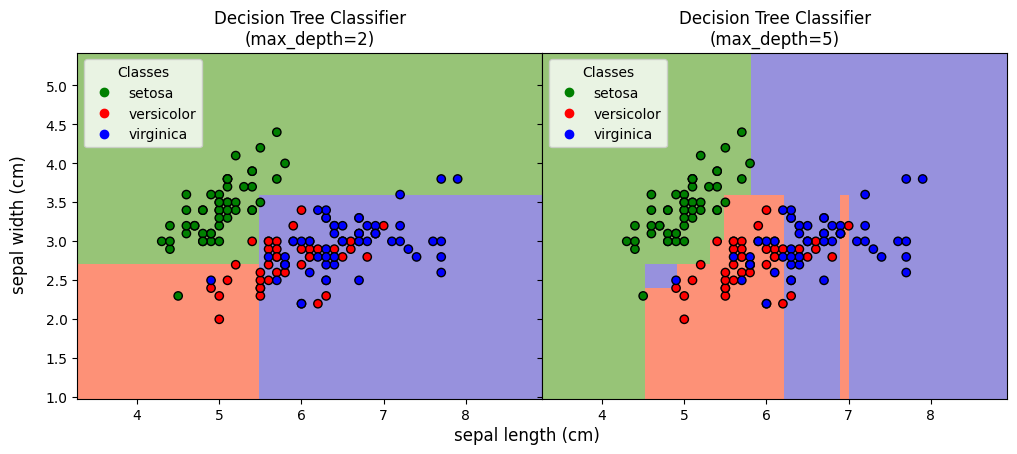

In [4]:
fig, axs = plt.subplots(
    ncols=2,
    sharex="col",
    sharey="row",
    figsize=(12, 4.5),
    # facecolor="#ded7b7fb",
    gridspec_kw={"wspace": 0, "hspace": 0},
)

for ax, depth in zip(axs, (2, 5)):
    clf = DecisionTreeClassifier(max_depth=depth).fit(X, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        plot_method="pcolormesh",
        ax=ax,
        cmap=ListedColormap(["#97c477", "#fd9177", "#9791dd"]),
    )
    scatter = disp.ax_.scatter(
        X[:, 0],
        X[:, 1],
        cmap=ListedColormap(["#008000", "#ff0000", "#0000ff"]),
        c=y,
        edgecolors="k",
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        iris.target_names,
        loc="upper left",
        title="Classes",
    )
    _ = disp.ax_.set_title(f"Decision Tree Classifier\n(max_depth={depth})")

fig.supxlabel("sepal length (cm)")
fig.supylabel("sepal width (cm)", x=0.069)

plt.show()

In [5]:
clf = DecisionTreeClassifier().fit(X, y)
print(clf.export_text(feature_names=iris.feature_names, class_names=iris.target_names))

┌── sepal length (cm)
│  ├── sepal width (cm) [> 5.50]
│  │  ├── sepal length (cm) [> 3.60]
│  │  │  ├── setosa [<= 5.80]
│  │  │  └── virginica [> 5.80]
│  │  └── sepal length (cm) [<= 3.60]
│  │     ├── sepal length (cm) [> 6.20]
│  │     │  ├── sepal length (cm) [<= 7.00]
│  │     │  │  ├── sepal width (cm) [<= 6.90]
│  │     │  │  │  ├── sepal length (cm) [> 2.30]
│  │     │  │  │  │  ├── sepal width (cm) [> 6.50]
│  │     │  │  │  │  │  ├── sepal length (cm) [<= 3.10]
│  │     │  │  │  │  │  │  ├── sepal width (cm) [> 6.60]
│  │     │  │  │  │  │  │  │  ├── sepal width (cm) [> 2.50]
│  │     │  │  │  │  │  │  │  │  ├── sepal length (cm) [> 2.80]
│  │     │  │  │  │  │  │  │  │  │  ├── sepal length (cm) [> 6.70]
│  │     │  │  │  │  │  │  │  │  │  │  ├── virginica [<= 6.80]
│  │     │  │  │  │  │  │  │  │  │  │  └── virginica [> 6.80]
│  │     │  │  │  │  │  │  │  │  │  └── sepal width (cm) [<= 6.70]
│  │     │  │  │  │  │  │  │  │  │     ├── versicolor [<= 3.00]
│  │     │  │  │  

In [6]:
x_axis = range(1, 250, 10)
y_axis = []

for x in x_axis:
    X = np.array([[i] for i in range(x)])
    y = np.arange(len(X))

    start = time.time()
    DecisionTreeClassifier().fit(X, y)
    end = time.time()

    y_axis.append((end - start) * 1000)

In [7]:
time_data = pd.read_csv("time_data.csv", header=None)

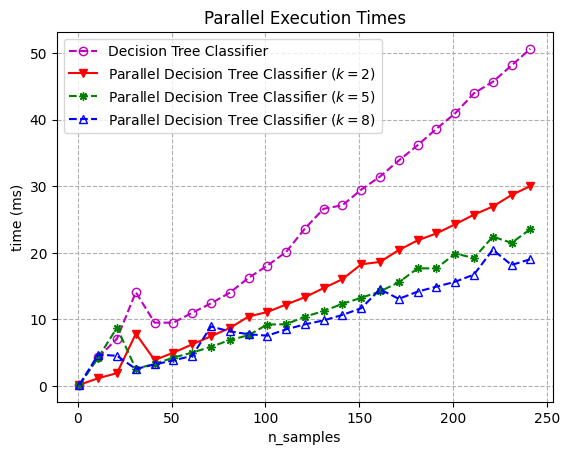

In [8]:
fig = plt.figure()
# fig.set_facecolor("#ded7b7fb")
ax = fig.add_subplot()

ax.plot(
    x_axis,
    y_axis,
    c="m",
    marker="o",
    ls="--",
    label="Decision Tree Classifier",
    fillstyle="none",
)

ax.plot(
    x_axis,
    time_data.iloc[0],
    c="r",
    marker="v",
    ls="-",
    label="Parallel Decision Tree Classifier $(k=2)$",
)

ax.plot(
    x_axis,
    time_data.iloc[1],
    c="g",
    marker=(8, 2, 0),
    ls="--",
    label="Parallel Decision Tree Classifier $(k=5)$",
)

ax.plot(
    x_axis,
    time_data.iloc[2],
    c="b",
    marker="^",
    ls="--",
    label="Parallel Decision Tree Classifier $(k=8)$",
    fillstyle="none",
)

# ax.set_facecolor("#fff4c4")
ax.set_xlabel("n_samples")
ax.set_ylabel("time (ms)")

plt.title("Parallel Execution Times")
plt.legend(loc=2)
plt.grid(ls="--")
plt.show()

In [9]:
from sklearn.datasets import load_digits

digits = load_digits()

X = digits.data
y = digits.target

clf = DecisionTreeClassifier(max_depth=4).fit(X, y)
print(
    clf.export_text(feature_names=digits.feature_names, class_names=digits.target_names)
)

┌── pixel_5_2
│  ├── pixel_4_4 [> 7.00]
│  │  ├── pixel_6_6 [> 0.00]
│  │  │  ├── pixel_2_5 [> 1.00]
│  │  │  │  ├── 6 [<= 0.00]
│  │  │  │  └── 8 [> 0.00]
│  │  │  └── pixel_4_6 [<= 1.00]
│  │  │     ├── 8 [<= 0.00]
│  │  │     └── 4 [> 0.00]
│  │  └── pixel_2_5 [<= 0.00]
│  │     ├── pixel_3_3 [> 0.00]
│  │     │  ├── 0 [<= 14.00]
│  │     │  └── 8 [> 14.00]
│  │     └── pixel_1_2 [<= 0.00]
│  │        ├── 4 [<= 7.00]
│  │        └── 5 [> 7.00]
│  └── pixel_3_2 [<= 7.00]
│     ├── pixel_2_5 [> 8.00]
│     │  ├── pixel_2_4 [> 3.00]
│     │  │  ├── 9 [<= 15.00]
│     │  │  └── 1 [> 15.00]
│     │  └── pixel_0_5 [<= 3.00]
│     │     ├── 1 [<= 3.00]
│     │     └── 5 [> 3.00]
│     └── pixel_5_3 [<= 8.00]
│        ├── pixel_6_5 [> 2.00]
│        │  ├── 7 [<= 0.00]
│        │  └── 2 [> 0.00]
│        └── pixel_3_6 [<= 2.00]
│           ├── 3 [<= 1.00]
│           └── 9 [> 1.00]


In [10]:
random_indices = np.random.choice(X.shape[0], 64, replace=False)

X_random = X[random_indices].reshape(8, 8, 64)
y_random = y[random_indices].reshape(8, 8)

images_random = digits.images[random_indices]

In [11]:
test_images = digits.images[random_indices].reshape(8, 8, 8, 8)

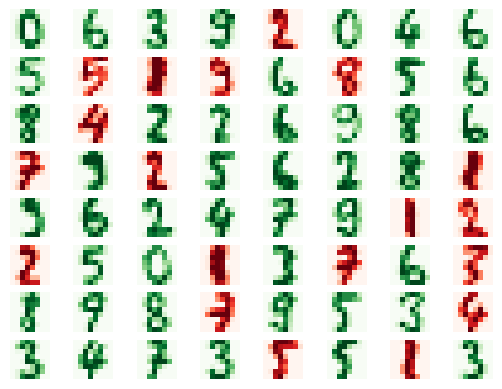

In [12]:
ROWS = COLS = 8

fig, axs = plt.subplots(
    nrows=ROWS,
    ncols=COLS,
)

for i in range(ROWS):
    for j in range(COLS):
        pred = clf.predict(X_random[i, j].reshape(1, -1))
        axs[i, j].imshow(
            test_images[i, j],
            cmap=plt.cm.Greens if pred == y_random[i, j] else plt.cm.Reds,
            interpolation="nearest",
        )
        axs[i, j].set_axis_off()

In [13]:
clf.predict(X_random.reshape(64, 64)).reshape(ROWS, COLS)

array([[0, 6, 3, 9, 8, 0, 4, 6],
       [5, 9, 8, 3, 6, 9, 5, 6],
       [8, 9, 2, 2, 6, 9, 8, 6],
       [9, 9, 8, 5, 6, 2, 8, 8],
       [9, 6, 2, 4, 7, 9, 2, 1],
       [8, 5, 0, 8, 3, 9, 6, 2],
       [8, 9, 8, 9, 9, 5, 3, 9],
       [3, 4, 7, 3, 7, 5, 7, 3]])